# Ensemble methods:

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.


Two families of ensemble methods are usually distinguished:

* In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

*Examples:* Bagging methods, Forests of randomized trees etc.

* By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

*Examples:* AdaBoost, Gradient Tree Boosting etc

In this assignment we will study two types of boosting techniques: **Ada-Boosting and Gradient Boosting**.

Boosting starts its journey with the question: **Can a set of weak learners create a single strong learner?** A weak learner is defined to be a classifier which is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

# 1. Ada-Boost

The module *sklearn.ensemble* includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire

The core principle of AdaBoost is to *fit a sequence of weak learners* (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through **a weighted majority vote (or sum) to produce the final prediction**. 

The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, ..., w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the **first step** simply trains a weak learner on the original data. **For each successive iteration**, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. **At a given step**, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. **As iterations proceed**, examples that are difficult to predict receive ever-increasing influence. **Each subsequent** weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence  

AdaBoost can be used both for classification and regression problems:
* For multi-class classification, AdaBoostClassifier implements AdaBoost-SAMME and AdaBoost-SAMME.R [ZZRH2009].
* For regression, AdaBoostRegressor implements AdaBoost.R2 

**class sklearn.ensemble.AdaBoostClassifier(Parameters)**

Parameters | 
-----------|--------------------------------------------------------------------
           | base_estimator : object, optional (default=DecisionTreeClassifier)
           | n_estimators : integer, optional (default=50)
           | learning_rate : float, optional (default=1.)
           | algorithm : {‘SAMME’, ‘SAMME.R’}, optional (default=’SAMME.R’)
           | random_state : int, RandomState instance or None, optional (default=None)



The following *example* shows how to fit an AdaBoost classifier with 100 weak learners:

In [1]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target)
scores.mean()

0.95996732026143794

* The **learning_rate** parameter controls the contribution of the weak learners in the final combination. By default, weak learners are decision stumps. Different weak learners can be specified through the base_estimator parameter. 
* The main parameters to tune to obtain good results are **n_estimators** and the complexity of the base estimators (e.g., its depth **max_depth** or minimum required number of samples at a leaf **min_samples_leaf** in case of decision trees).

**Exercise:**

1. The number of weak learners is controlled by the parameter number of estimator i.e. **n_estimators**. Change the number of estimator and see how the end results differ.

Here is another example:

Automatically created module for IPython interactive environment


/home/altairmn/test/iith_ws/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


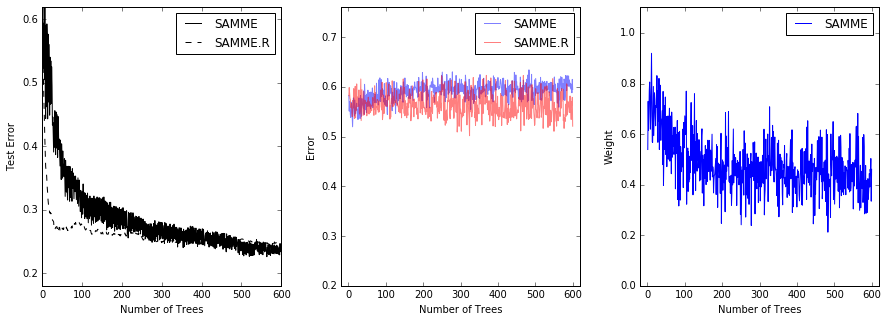

In [2]:
print(__doc__)

# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


X, y = make_gaussian_quantiles(n_samples=13000, n_features=10,
                               n_classes=3, random_state=1)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

**Question:**
1. Change n_samples, n_features, n_classes, random_state and see the result? Are those affecting the total running time?

# 2. Gradient Tree Boosting

**Gradient Tree Boosting** or **Gradient Boosted Regression Trees** (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

The advantages of GBRT are:

* Natural handling of data of mixed type (= heterogeneous features)
* Predictive power
* Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

* Scalability, due to the sequential nature of boosting it can hardly be parallelized.

The module *sklearn.ensemble* provides methods for both classification and regression via gradient boosted regression trees.

A. **Classification:** GradientBoostingClassifier supports both binary and multi-class classification. The following example shows how to fit a gradient boosting classifier with 100 decision stumps as weak learners:

In [3]:
>>> from sklearn.datasets import make_hastie_10_2
>>> from sklearn.ensemble import GradientBoostingClassifier

>>> X, y = make_hastie_10_2(random_state=0)
>>> X_train, X_test = X[:2000], X[2000:]
>>> y_train, y_test = y[:2000], y[2000:]

>>> clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=1, random_state=0).fit(X_train, y_train)
>>> clf.score(X_test, y_test)                 

0.91300000000000003

**Exercise:**
* The number of weak learners (i.e. regression trees) is controlled by the parameter n_estimators. Change that and see the result.
* Change the parameter max_depth, you can see that the size of each tree can be controlled by this parameter.
* The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage, change that parameter and see the final result.

B. **Regression:** GradientBoostingRegressor supports a number of different loss functions for regression which can be specified via the argument loss; the default loss function for regression is least squares ('ls').

**The following loss functions are supported and can be specified using the parameter loss:**

* Regression
            1. Least squares ('ls'): The natural choice for regression due to its superior computational properties. The initial model is given by the mean of the target values.
            2. Least absolute deviation ('lad'): A robust loss function for regression. The initial model is given by the median of the target values.
            3. Huber ('huber'): Another robust loss function that combines least squares and least absolute deviation; use alpha to control the sensitivity with regards to outliers (see [F2001] for more details).
            4. Quantile ('quantile'): A loss function for quantile regression. Use 0 < alpha < 1 to specify the quantile. This loss function can be used to create prediction intervals (see Prediction Intervals for Gradient Boosting Regression).
* Classification
            1. Binomial deviance ('deviance'): The negative binomial log-likelihood loss function for binary classification (provides probability estimates). The initial model is given by the log odds-ratio.
            2. Multinomial deviance ('deviance'): The negative multinomial log-likelihood loss function for multi-class classification with n_classes mutually exclusive classes. It provides probability estimates. The initial model is given by the prior probability of each class. At each iteration n_classes regression trees have to be constructed which makes GBRT rather inefficient for data sets with a large number of classes.
            3. Exponential loss ('exponential'): The same loss function as AdaBoostClassifier. Less robust to mislabeled examples than 'deviance'; can only be used for binary classification.



In [4]:
>>> import numpy as np
>>> from sklearn.metrics import mean_squared_error
>>> from sklearn.datasets import make_friedman1
>>> from sklearn.ensemble import GradientBoostingRegressor

>>> X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
>>> X_train, X_test = X[:200], X[200:]
>>> y_train, y_test = y[:200], y[200:]
>>> est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
...     max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
>>> mean_squared_error(y_test, est.predict(X_test))  

5.0091548599603213

**Exercise:**
* Change the loss function and see the performance change.

Both *GradientBoostingRegressor* and *GradientBoostingClassifier* support **warm_start=True** which allows you to add more estimators to an already fitted model.

C. **Controlling the tree size:** The size of the regression tree base learners defines the level of variable interactions that can be captured by the gradient boosting model. In general, a tree of depth h can capture interactions of order h . There are two ways in which the size of the individual regression trees can be controlled.

If you specify max_depth=h then complete binary trees of depth h will be grown. Such trees will have (at most) 2^h leaf nodes and 2^h - 1 split nodes.

Alternatively, you can control the tree size by specifying the number of leaf nodes via the parameter max_leaf_nodes. In this case, trees will be grown using best-first search where nodes with the highest improvement in impurity will be expanded first. A tree with max_leaf_nodes=k has k - 1 split nodes and thus can model interactions of up to order max_leaf_nodes - 1 .

We found that max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error. The parameter max_leaf_nodes corresponds to the variable J in the chapter on gradient boosting in [F2001] and is related to the parameter interaction.depth in R’s gbm package where max_leaf_nodes == interaction.depth + 1 .

D. **Regularization:** a simple regularization strategy that scales the contribution of each weak learner by a factor \nu:

F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)

The parameter \nu is also called the learning rate because it scales the step length the the gradient descent procedure; it can be set via the learning_rate parameter.

The parameter learning_rate strongly interacts with the parameter n_estimators, the number of weak learners to fit. Smaller values of learning_rate require larger numbers of weak learners to maintain a constant training error. Empirical evidence suggests that small values of learning_rate favor better test error. 

E. **Interpretation:** Individual decision trees can be interpreted easily by simply visualizing the tree structure. Gradient boosting models, however, comprise hundreds of regression trees thus they cannot be easily interpreted by visual inspection of the individual trees. Fortunately, a number of techniques have been proposed to summarize and interpret gradient boosting models.

* Feature importance: Often features do not contribute equally to predict the target response; in many situations the majority of the features are in fact irrelevant. When interpreting a model, the first question usually is: what are those important features and how do they contributing in predicting the target response?

Individual decision trees intrinsically perform feature selection by selecting appropriate split points. This information can be used to measure the importance of each feature; the basic idea is: the more often a feature is used in the split points of a tree the more important that feature is. This notion of importance can be extended to decision tree ensembles by simply averaging the feature importance of each tree

The feature importance scores of a fit gradient boosting model can be accessed via the feature_importances_ property:

In [5]:
>>> from sklearn.datasets import make_hastie_10_2
>>> from sklearn.ensemble import GradientBoostingClassifier

>>> X, y = make_hastie_10_2(random_state=0)
>>> clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=1, random_state=0).fit(X, y)
>>> clf.feature_importances_  

array([ 0.11,  0.1 ,  0.11,  0.1 ,  0.09,  0.11,  0.09,  0.1 ,  0.1 ,  0.09])